In [13]:
from jax_samplers.distributions import DoublyIntractableLogDensity
from jax_samplers.distributions import maybe_wrap, maybe_wrap_log_l
import numpyro.distributions as np_distributions
import jax

def make_slcp_posterior(x_obs, doubly_intractable=False):
    prior = np_distributions.Uniform(low=-3 * jnp.ones((5,)), high=3 * jnp.ones((5,)), validate_args=True).to_event()
    def log_likelihood(theta, x):
        m = theta[:2]

        s1 = theta[2] ** 2
        s2 = theta[3] ** 2
        rho = jax.nn.tanh(theta[4])

        S = jnp.array(
            [
                [s1 ** 2, rho * s1 * s2],
                [rho * s1 * s2, s2 ** 2],
            ]
        ) + 1e-8 * jnp.eye(2)

        inv_S = jnp.linalg.inv(S)
        log_det_S =  jnp.log(jnp.linalg.det(S))

        def _single_loglik(x_sub):
            ret = - 0.5 * (x_sub - m) @ inv_S @ (x_sub - m)
            if doubly_intractable:
                return ret
            else:
                # add normalizer
                return ret - 0.5 * log_det_S

        return _single_loglik(x[:2]) + _single_loglik(x[2:4]) + _single_loglik(x[4:6]) + _single_loglik(x[6:])

    doubly_intractable_log_prob = DoublyIntractableLogDensity(
        log_prior=maybe_wrap(prior.log_prob),
        log_likelihood=maybe_wrap_log_l(log_likelihood),
        x_obs=x_obs,
    )
    return doubly_intractable_log_prob

In [14]:
from jax import random
import jax.numpy as jnp

prior = np_distributions.Uniform(low=-3 * jnp.ones((5,)), high=3 * jnp.ones((5,))).to_event()
x_obs = jnp.array([  2.3719,   0.4995,   9.9314,   1.7137, -10.4364,  -1.9068,  -1.2344, -0.0974])
slcp_log_posterior = make_slcp_posterior(x_obs)

In [15]:
import pickle
with open('reference_posterior_samples.pkl', 'rb') as f:
    pst = pickle.load(f)

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def pairplot(samples, f=None, axs=None):
    if isinstance(samples, (np.ndarray, jnp.ndarray)):
        samples = {'samples': samples}
        
    if axs is None:
        f, axs = plt.subplots(ncols=5, nrows=5)
        
    dim_samples = list(samples.values())[0].shape[1]
    
    for s_name, s in samples.items():
        for i in range(dim_samples):
            for j in range(dim_samples):
                axs[i, j].yaxis.set_ticks([])
                axs[i, j].yaxis.set_ticklabels([])

                axs[i, j].xaxis.set_ticks([])
                axs[i, j].xaxis.set_ticklabels([])

                if i == j:
                    axs[i, j].hist(s[:, i], bins=50, label=s_name, alpha=0.5, density=True)
                    axs[i, j].set_xlim((-3, 3))
                else:
                    axs[i, j].scatter(s[:, i], s[:, j], s=1, label=s_name, alpha=0.1)
                    axs[i, j].set_xlim((-3, 3))
                    axs[i, j].set_ylim((-3, 3))
                
        axs[0, 0].legend(bbox_to_anchor=(0, 1), bbox_transform=axs[0, 0].transAxes)
    
    return axs

In [17]:
from jax_samplers.kernels.savm import SAVMKernelFactory, SAVMConfig
from jax_samplers.kernels.mala import MALAKernelFactory, MALAConfig
from jax_samplers.kernels.rwmh import RWKernelFactory, RWConfig
from jax_samplers.kernels.nuts import NUTSKernelFactory, NUTSConfig
from jax_samplers.kernels.hmc import HMCKernelFactory, HMCConfig
from jax_samplers.kernels.numpyro_barker_mh import BarkerMHKernelFactory, BarkerMHConfig
from jax_samplers.kernels.numpyro_nuts import NUTSKernelFactory, NUTSConfig
from jax_samplers import MCMCAlgorithm, MCMCConfig

In [21]:
from jax import jit
kf = MALAKernelFactory(config=MALAConfig(step_size=0.0001, C=jnp.ones((5,))))
kf = NUTSKernelFactory(config=NUTSConfig(step_size=0.00001, C=jnp.eye(5), max_tree_depth=10))
# kf = RWKernelFactory(config=RWConfig(step_size=0.1, C=jnp.eye(5)))
# kf = BarkerMHKernelFactory(config=BarkerMHConfig(step_size=0.00001, C=jnp.eye(5)))
# kf = BarkerMHKernelFactory(config=BarkerMHConfig(step_size=0.00001, C=jnp.ones((5,))))
# kf = NUTSKernelFactory(config=NUTSConfig(step_size=0.00001, C=jnp.ones((5,))))

alg = MCMCAlgorithm.create(
    config=MCMCConfig(
        num_samples=10000, record_trajectory=True, kernel_factory=kf, num_warmup_steps=1000, adapt_step_size=True, adapt_mass_matrix=True, thinning_factor=1, num_chains=100, target_accept_rate=0.5, progress_bar=True),
    log_prob=slcp_log_posterior
)

In [38]:
from jax import random
key = random.PRNGKey(0)
key, subkey = random.split(key)
alg = alg.init_from_particles(prior.sample(key=subkey, sample_shape=(alg.config.num_chains,)))

key, subkey = random.split(key)
alg, results = jit(alg.run)(subkey)
# alg, results = alg.run(subkey)

  0%|          | 0/600000 [00:00<?, ?it/s]

In [23]:
# results.info.single_chain_results.final_state._numpyro_state.adapt_state.inverse_mass_matrix
# alg._single_chains.config.kernel_factory.config.C

In [34]:
# results.info.single_chain_results.final_state._numpyro_state.accept_prob
# results.info.single_chain_results.info
# results.info.single_chain_results.final_state._numpyro_state.adapt_state.step_size

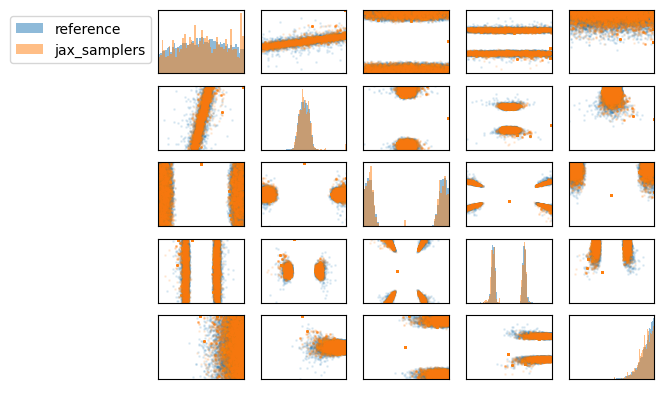

In [24]:
axs = pairplot({'reference': pst, 'jax_samplers': results.samples.xs})
# axs = pairplot({'reference': pst})

In [25]:
# from numpyro.infer import HMC, MCMC, BarkerMH, NUTS
# import jax.numpy as jnp                                                                                                                                                   
# 
# numpyro_sampler = MCMC(
#     # sampler=HMC(potential_fn=lambda x: -slcp_log_posterior(x), inverse_mass_matrix=jnp.eye(5), dense_mass=True, adapt_mass_matrix=False,
#     #            adapt_step_size=True, step_size=0.01),
#     # sampler=BarkerMH(potential_fn=lambda x: -slcp_log_posterior(x), adapt_mass_matrix=True, adapt_step_size=True, dense_mass=False, step_size=0.0001),
#     sampler=NUTS(potential_fn=lambda x: -slcp_log_posterior(x), adapt_mass_matrix=True, adapt_step_size=True, dense_mass=True, step_size=0.0001),
#     # num_warmup=1000, num_samples=100, num_chains=100, chain_method="vectorized", thinning=1, progress_bar=False
#     num_warmup=1000, num_samples=100, num_chains=100, chain_method="sequential", thinning=1, progress_bar=False
# )
# numpyro_sampler.run(random.PRNGKey(1), init_params=prior.sample(key=random.PRNGKey(2), sample_shape=(numpyro_sampler.num_chains,)))
# numpyro_samples = numpyro_sampler.get_samples()
# axs = pairplot({'reference': pst, 'numpyro': numpyro_samples})

In [29]:
from jax import random
import jax.numpy as jnp

prior = np_distributions.Uniform(low=-3 * jnp.ones((5,)), high=3 * jnp.ones((5,))).to_event()
x_obs = jnp.array([  2.3719,   0.4995,   9.9314,   1.7137, -10.4364,  -1.9068,  -1.2344, -0.0974])
doubly_intractable_slcp_log_posterior = make_slcp_posterior(x_obs, doubly_intractable=True)

In [30]:
from jax import jit
kf = MALAKernelFactory(config=MALAConfig(step_size=0.1, C=jnp.ones((5,))))
kf = RWKernelFactory(config=RWConfig(step_size=0.1, C=jnp.eye(5)))
alg = MCMCAlgorithm.create(
    config=MCMCConfig(
        num_samples=10000, record_trajectory=False, kernel_factory=kf, num_warmup_steps=5000, adapt_step_size=True, adapt_mass_matrix=True, thinning_factor=10, num_chains=100, target_accept_rate=0.5, progress_bar=True),
    log_prob=doubly_intractable_slcp_log_posterior
)

In [31]:
from jax import random
key = random.PRNGKey(0)
key, subkey = random.split(key)
alg = alg.init_from_particles(prior.sample(key=subkey, sample_shape=(alg.config.num_chains,)))
key, subkey = random.split(key)
# alg_savm, results_savm = jit(alg_savm.run)(subkey)
alg, results = alg.run(subkey)

  0%|          | 0/600000 [00:00<?, ?it/s]

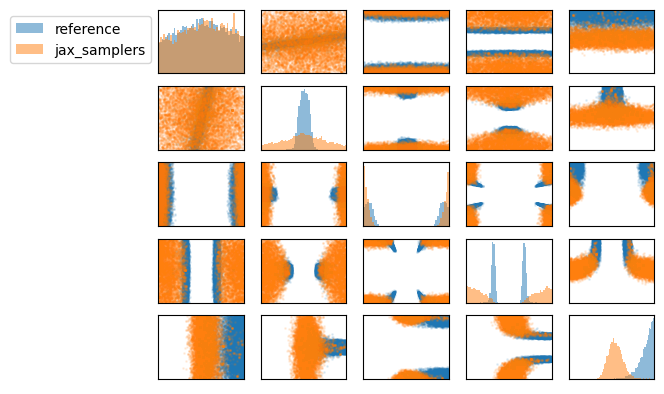

In [32]:
axs = pairplot({'reference': pst, 'jax_samplers': results.samples.xs})

In [33]:
from jax import jit
kf = SAVMKernelFactory(
    config=SAVMConfig(
        base_var_kernel_factory=RWKernelFactory(config=RWConfig(step_size=1., C=jnp.ones((5,)))),
        # base_var_kernel_factory=RWKernelFactory(config=RWConfig(step_size=1., C=jnp.eye(5))),
        # aux_var_kernel_factory=MALAKernelFactory(MALAConfig(step_size=1., C=jnp.ones((8,)))),
        # aux_var_kernel_factory=NUTSKernelFactory(NUTSConfig(step_size=1., inverse_mass_matrix=jnp.ones((8,)))),
        # aux_var_kernel_factory=HMCKernelFactory(HMCConfig(step_size=1., inverse_mass_matrix=jnp.eye(8), num_integration_steps=3)),
        # aux_var_kernel_factory=RWKernelFactory(RWConfig(step_size=1., C=jnp.ones((8,)))),
        aux_var_kernel_factory=RWKernelFactory(RWConfig(step_size=1., C=jnp.ones((8,)))),
        # aux_var_kernel_factory=NUTSKernelFactory(NUTSConfig(step_size=1., C=jnp.ones((8,)))),
        aux_var_num_inner_steps=100, aux_var_init_strategy="warm"
    )
)
# kf = MALAKernelFactory(config=MALAConfig(step_size=0.1))
alg_savm = MCMCAlgorithm.create(
    config=MCMCConfig(num_samples=10000, record_trajectory=True, kernel_factory=kf, num_warmup_steps=3000, adapt_step_size=True, adapt_mass_matrix=True, thinning_factor=10, num_chains=100),
    log_prob=doubly_intractable_slcp_log_posterior
)

In [34]:
# from jax import jit
# kf = SAVMKernelFactory(
#     config=SAVMConfig(
#         # base_var_kernel_factory=RWKernelFactory(config=RWConfig(step_size=1., C=jnp.ones((5,)))),
#         base_var_kernel_factory=RWKernelFactory(config=RWConfig(step_size=1., C=jnp.eye(5))),
#         # aux_var_kernel_factory=MALAKernelFactory(MALAConfig(step_size=1., C=jnp.ones((8,)))),
#         # aux_var_kernel_factory=NUTSKernelFactory(NUTSConfig(step_size=1., inverse_mass_matrix=jnp.ones((8,)))),
#         # aux_var_kernel_factory=HMCKernelFactory(HMCConfig(step_size=1., inverse_mass_matrix=jnp.eye(8), num_integration_steps=3)),
#         # aux_var_kernel_factory=RWKernelFactory(RWConfig(step_size=1., C=jnp.ones((8,)))),
#         # aux_var_kernel_factory=RWKernelFactory(RWConfig(step_size=1., C=jnp.ones((8,)))),
#         # aux_var_kernel_factory=NUTSKernelFactory(NUTSConfig(step_size=1., C=jnp.ones((8,)), max_tree_depth=2)),
#         # aux_var_kernel_factory=NUTSKernelFactory(NUTSConfig(step_size=1., C=jnp.eye(8), max_tree_depth=2)),
#         # aux_var_kernel_factory=BarkerMHKernelFactory(BarkerMHConfig(step_size=1., C=jnp.eye(8))),
#         aux_var_kernel_factory=RWKernelFactory(RWConfig(step_size=1., C=None)),
#         aux_var_num_inner_steps=200, aux_var_init_strategy="warm"
#     )
# )
# # kf = MALAKernelFactory(config=MALAConfig(step_size=0.1))
# alg_savm = MCMCAlgorithm.create(
#     config=MCMCConfig(num_samples=10000, record_trajectory=True, kernel_factory=kf, num_warmup_steps=5000, adapt_step_size=True, adapt_mass_matrix=True, thinning_factor=1, num_chains=100, progress_bar=True, target_accept_rate=0.5),
#     log_prob=doubly_intractable_slcp_log_posterior
# )

In [35]:
key = random.PRNGKey(0)
key, subkey = random.split(key)
alg_savm = alg_savm.init_from_particles(prior.sample(key=subkey, sample_shape=(alg_savm.config.num_chains,)))
key, subkey = random.split(key)
# alg_savm, results_savm = jit(alg_savm.run)(subkey)
alg_savm, results_savm = jit(alg_savm.run)(subkey)
# print(results_savm)

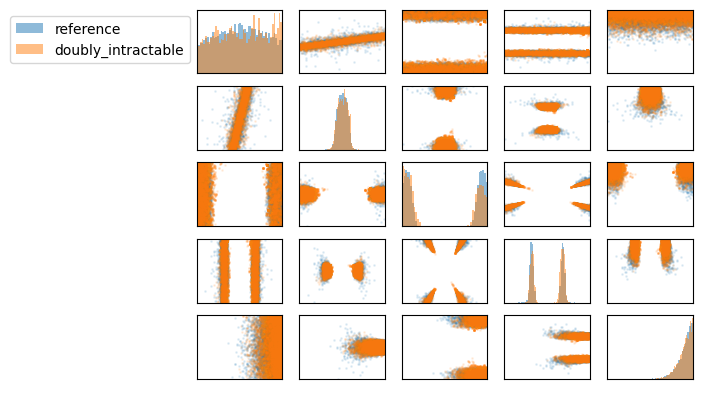

In [36]:
axs = pairplot({'reference': pst, 'doubly_intractable': results_savm.samples.xs})